In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys 
import numpy as np
import math
import numba
from numba import cuda, int64, jit
from numba.cuda import random as rnd
from timeit import default_timer as timer
from scipy.stats import binom, poisson
import pickle as pkl
import os
os.system("ml CUDA")

0

First we like to sample a unformly distributed random variable. For our example later this can represent sampling a random parent for a cell.
<img src="figures/schema1.png">




In [ ]:
@cuda.jit
def neutral(rng_states,parents,N):
    cellID = cuda.grid(1)
    #this is how you would get a uniformly distributed random variable
    parent=int(math.floor(N*rnd.xoroshiro128p_uniform_float32(rng_states, cellID)))
    parents[cellID]=parent

In [ ]:
@cuda.jit
def sumF(fitnessarr,F):
    F[0]=0
    for i in range(fitnessarr.shape[0]):
        F[0]+=fitnessarr[i]

Second we like to sample a multinomially distributed random variable according to the weights stored in fitnessarr. (Note that in F we have the sum of fitnessarr stored).

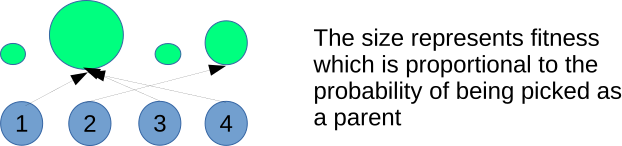


In [ ]:
@cuda.jit
def multinomial(rng_states,parents,fitnessarr,F):
    cellID = cuda.grid(1)
    #this is how you would get a multinomially distributed random variable
    r=F[0]*rnd.xoroshiro128p_uniform_float32(rng_states, cellID)
    for i in range(len(fitnessarr)):
        if r<fitnessarr[i]:
            parent=i
            break
        else:
            r-=fitnessarr[i]
    parents[cellID]=parent

Second we want to sample a binomially distributed random variable (eg. the number of new muations for a cell) where the parameter of the distribution is the same for every instance. Therefore we prepare a cumulative mass function of the binomial with the chosen paramter (p2 in the main part). Aterwards we sample a uniform and using the cumulative transform it into a binomially distributed random variable.

In [ ]:
@cuda.jit
def binomial(rng_states,binomcdf,nummutations):
    cellID = cuda.grid(1)
    #this is for a binomially distibuted random variable, here doing a serial search should be fine. However, in some situations binary a binary search should be performed 
    r=rnd.xoroshiro128p_uniform_float32(rng_states, cellID)
    for numberMutations in range(100):
        if r < binomcdf[numberMutations]:
            break
    nummutations[cellID]=numberMutations

Now we want to combine some of these distributions: We want sample a random parent according to a multinomial distribution. A number of mutations accroding to a binomial and place these mutations uninformly on the genome. Last we have to compute the number of mismatches between the cells genome and the reference in order to reclibrate the multinomials distribution. Here the fitness is proportional to the number of SNPs. 

In [ ]:
@cuda.jit
def evolve(rng_states,gen,genotypes,reference,binomcdf,fitnessarr,F):
    genoblocks = genotypes.shape[1]/2
    cellID = cuda.grid(1)
    #this is how you would get a multinomially distributed random variable
    r=F[0]*rnd.xoroshiro128p_uniform_float32(rng_states, cellID)
    for i in range(len(fitnessarr)):
        if r<fitnessarr[i]:
            parent=i
            break
        else:
            r-=fitnessarr[i]
    #this is for a binomially distibuted random variable, here doing a serial search should be fine. However, in some situations binary a binary search should be performed 
    r=rnd.xoroshiro128p_uniform_float32(rng_states, cellID)
    for numberMutations in range(100):
        if r < binomcdf[numberMutations]:
            break
    for i in range(numberMutations):
        #this is for a uniformly distributed integer
        pos = 2*int(math.floor(L/2*rnd.xoroshiro128p_uniform_float32(rng_states, cellID)))
        posInt = pos//64
        posInInt = pos%64
        #this is just a simple uniformly distributed float
        r=rnd.xoroshiro128p_uniform_float32(rng_states, cellID)
        if r < 1/4:
             #transverion (first bit with probability 1/2)
            if r < 1/8:
                genotypes[cellID,posInt]=genotypes[cellID,posInt] ^ 2**posInInt
                #second bit has to be flipped
                genotypes[cellID,posInt]=genotypes[cellID,posInt] ^ 2**(posInInt+1)
        else:
            #transition (00<->10 or 01<->11)
            genotypes[cellID,posInt]=genotypes[cellID,posInt] ^ 2**posInInt
    snpCount=0
    for posInt in range(genoblocks):
        intAnd=(genotypes[cellID,posInt] ^ reference[posInt])
        for posInInt in range(0,64,2):
            if intAnd & 2**posInInt > 0 or intAnd & 2**(posInInt+1) > 0:
                snpCount+=1
    #here we prepare the multinomial for the next interation
    fitnessarr[cellID]=1+snpCount

Main part of the code:

In [ ]:
L=1000
n=64*L
threadsperblock = 10
blocks = 10
N=threadsperblock*blocks
fractionvariable=0.9
p2=0.00001
binomcdf = np.zeros((100),dtype=np.float32)
for k in range(100):
    binomcdf[k]=binom.cdf(k, n, p2)
SEED=1
genotypes = np.array(np.reshape(np.array(list(np.random.randint(0,2**64, L,dtype=np.uint64))*2*N),(N,L*2)), dtype=np.uint64)
devgenotypes = cuda.to_device(genotypes)
reference = np.copy(genotypes[0,:])
devreference = cuda.to_device(reference)
devbinomcdf = cuda.to_device(binomcdf)
fitnessarr = np.ones(N)
parents = np.zeros(N)
devparents = cuda.to_device(parents)
nummutations = np.zeros(N)
devnummutations = cuda.to_device(nummutations)
devfitnessarr=cuda.to_device(fitnessarr)
rng_states = rnd.create_xoroshiro128p_states(threadsperblock * blocks, seed=SEED)
F=cuda.device_array((1))
sumF[1,1](devfitnessarr,F)

Let's start with a uniform probability for picking parents.

In [ ]:
neutral[blocks, threadsperblock](rng_states,devparents,N)
parents=devparents.copy_to_host()
print(parents)

[13. 87. 87. 93. 60. 34. 47. 33. 40. 29. 44. 85.  7.  8. 52. 65. 98.  8.
 87. 85. 99.  2. 20. 29. 72. 82. 77. 56. 92. 25. 25. 52. 47. 94. 21. 99.
 75. 82. 85. 36. 81. 89. 10. 59. 57. 92. 88. 81. 22. 60.  6. 79. 17. 77.
 33.  7. 32. 71. 80. 26. 79. 15. 86. 72. 36. 73. 72. 86. 25. 76.  1.  6.
 57. 48. 52. 74. 68.  0. 42. 85. 88. 18.  5. 38.  8. 83. 40. 83. 38. 49.
 78. 48. 76. 82. 91. 23. 77. 77. 64. 84.]


Now we use a uniform fitness landscape. I.e., a multinomial where every parent has the same probability of beeing selected. (That is the same as uniform from above)

In [ ]:
multinomial[blocks, threadsperblock](rng_states,devparents,devfitnessarr,F)
parents=devparents.copy_to_host()
print(parents)

[37. 21. 45. 92. 40. 81. 78. 86. 47. 78. 76. 47. 36. 61. 68.  6. 94. 72.
 58. 12.  5.  7. 44. 57. 13. 22. 24. 20. 56. 26. 61. 38.  0. 18. 56. 94.
 57. 40. 76. 22. 75. 94. 37. 25. 41. 80. 59.  9. 67.  4. 97. 60. 53. 56.
 79. 22. 92. 55. 27. 95. 84. 89. 65. 63. 61. 93. 34.  6. 84. 55. 53.  1.
 31. 71. 39. 17. 85. 99.  2. 71. 48. 69.  6. 78. 55. 33. 93. 34.  2. 94.
 38. 85. 24. 47. 53. 69. 12. 31. 23. 54.]


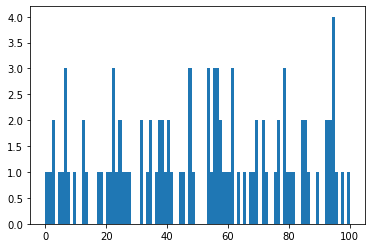

In [ ]:
fitnessarr=devfitnessarr.copy_to_host()
plt.hist(parents,bins=range(0,101,1))
plt.show()

Now let's skew it towards the cell number 0:

In [ ]:
fitnessarr = np.ones(N)
fitnessarr[0]=100.0
F=cuda.device_array((1))
devfitnessarr=cuda.to_device(fitnessarr)
sumF[1,1](devfitnessarr,F)
multinomial[blocks, threadsperblock](rng_states,devparents,devfitnessarr,F)
parents=devparents.copy_to_host()
print(parents)

[ 0.  0. 73. 63. 26. 64.  0.  9.  0. 19.  0.  0.  0.  0. 23.  0.  0. 23.
  0. 31. 85. 13.  0.  1.  1. 10. 32.  0.  0.  0. 28. 89.  9.  0. 80. 60.
  7.  0. 16.  0.  0. 64. 59. 72.  0.  0.  9. 95.  0.  0.  0. 50.  0. 82.
  2. 83. 77.  0.  0. 79.  0. 85. 44. 96.  0. 93.  2.  0.  0.  0. 23.  0.
 48. 30.  0.  0. 41. 61. 49.  0.  0.  0.  0.  0.  0. 66.  0.  4.  0.  0.
  5. 67.  0.  0. 84.  0.  0.  0.  0. 86.]


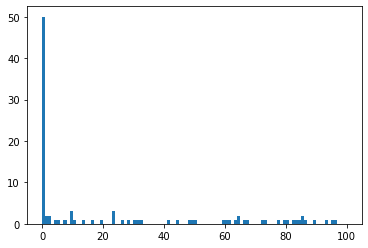

In [ ]:
fitnessarr=devfitnessarr.copy_to_host()
plt.hist(parents,bins=range(0,101,1))
plt.show()

In [ ]:
binomial[blocks, threadsperblock](rng_states,devbinomcdf,devnummutations)
nummutations=devnummutations.copy_to_host()
print(nummutations)

[0. 0. 1. 1. 2. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1.
 2. 2. 1. 3. 1. 2. 0. 1. 0. 2. 0. 2. 0. 0. 0. 0. 2. 0. 0. 0. 1. 0. 0. 0.
 2. 1. 0. 0. 1. 3. 2. 0. 0. 1. 0. 2. 1. 1. 0. 2. 0. 4. 0. 0. 1. 0. 1. 0.
 3. 2. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 3. 0. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 1.]


In [ ]:
start = timer()
evolve[blocks, threadsperblock](rng_states,0,devgenotypes,devreference,devbinomcdf,devfitnessarr,F)
sumF[1,1](devfitnessarr,F)
cuda.synchronize()
evolve_time=timer()-start
print("first iteration: "+str(evolve_time))
fitnessarr=devfitnessarr.copy_to_host()
print(fitnessarr)

first iteration: 0.8673899109708145
[3. 1. 2. 1. 1. 1. 1. 2. 2. 1. 2. 1. 1. 2. 1. 3. 1. 1. 2. 1. 1. 1. 2. 1.
 1. 2. 2. 1. 1. 2. 2. 2. 1. 1. 1. 1. 1. 2. 2. 1. 2. 1. 1. 1. 2. 3. 2. 2.
 1. 1. 2. 1. 1. 2. 2. 1. 1. 1. 1. 2. 3. 2. 1. 2. 1. 1. 1. 1. 1. 1. 2. 3.
 1. 1. 3. 2. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 2. 2. 2. 1. 2. 2. 1. 1. 2.
 1. 1. 1. 2.]


In [ ]:
start = timer()
evolve[blocks, threadsperblock](rng_states,1,devgenotypes,devreference,devbinomcdf,devfitnessarr,F)
sumF[1,1](devfitnessarr,F)
cuda.synchronize()
evolve_time=timer()-start
print("second iteration: "+str(evolve_time))
fitnessarr=devfitnessarr.copy_to_host()
print(fitnessarr)

second iteration: 0.025035894010215998
[3. 1. 4. 2. 3. 3. 1. 4. 2. 1. 3. 1. 1. 3. 1. 3. 1. 1. 2. 2. 4. 1. 2. 1.
 1. 6. 3. 1. 2. 3. 2. 3. 1. 2. 1. 1. 2. 3. 2. 1. 2. 3. 2. 3. 2. 3. 3. 3.
 2. 2. 3. 2. 1. 2. 2. 3. 2. 2. 1. 3. 3. 2. 2. 3. 1. 3. 1. 3. 1. 2. 2. 3.
 1. 1. 4. 2. 2. 1. 1. 1. 1. 1. 2. 2. 1. 2. 1. 2. 2. 3. 1. 2. 2. 1. 1. 2.
 1. 1. 1. 4.]
